In [1]:
# Use below line for demo in external colabs
# !pip install -q torchdata==0.3.0 torchtext==0.12 spacy==3.2 altair GPUtil
# !python -m spacy download de_core_news_sm
# !python -m spacy download en_core_web_sm
# !pip install -q git+https://github.com/nikitakapitan/transformers.git

In [1]:
import torch
import torch.nn as nn
import math
from transformers.main import make_model

from transformers.data.token import load_tokenizers
from transformers.data.vocab import load_vocab
from transformers.data.dataloader import create_dataloaders
from transformers.output import greedy_decode
from transformers.helper import following_mask

from transformers.data.Batch import Batch
from transformers.Embeddings import Embeddings
from transformers.PositionalEncoding import PositionalEncoding
from transformers.MultiHeadedAttention import MultiHeadedAttention
from transformers.LayerNorm import LayerNorm

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
# transformers.output.run_model_example(n_examples=5) :

spacy_de, spacy_en = load_tokenizers()
vocab_src, vocab_tgt = load_vocab(spacy_de=spacy_de, spacy_en=spacy_en)

_, valid_dataloader = create_dataloaders(
        torch.device("cpu"),
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=1,
        is_distributed=False,
    )

architecture = {
        'src_vocab_len' : len(vocab_src),
        'tgt_vocab_len' : len(vocab_tgt),
        'N' : 6, # loop
        'd_model' : 512, # emb
        'd_ff' : 2048,
        'h' : 8,
        'p_dropout' : 0.1
    }

model = make_model(
        src_vocab_len = architecture['src_vocab_len'], 
        tgt_vocab_len = architecture['tgt_vocab_len'], 
        N=6,
        d_model=architecture['d_model'], 
        d_ff = architecture['d_ff'],
        h = architecture['h'],
        dropout=architecture['p_dropout'])

model.load_state_dict(
    torch.load("multi30k_model_final.pt", map_location=torch.device("cpu"))
)


#NEXT
# example_data = check_outputs(valid_dataloader, model, vocab_src, vocab_tgt, n_examples)


Finished.
Vocabulary sizes:
len: SRC=8315 TGT=6384


In [5]:
# transformers.output.check_outputs(valid_dataloader, model, vocab_src, vocab_tgt)
pad_idx = 2
eos_string="</s>"

b = next(iter(valid_dataloader))
rb = Batch(b[0], b[1], pad=pad_idx)

src_tokens = [vocab_src.get_itos()[x] for x in rb.src[0] if x != pad_idx]
tgt_tokens = [vocab_tgt.get_itos()[x] for x in rb.tgt[0] if x != pad_idx]

# NEXT:
# model_out = greedy_decode(model, rb.src, rb.src_mask, max_len=72, start_symbol=0)[0]

In [7]:
# transfoemrs.output.greedy_decode()
src = rb.src
src_mask = rb.src_mask
max_len=72
start_symbol=0

memory = model.encode(src, src_mask)

target = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)


In [8]:
# i = 0
i = 0
tgt_mask = following_mask(target.size(1)).type_as(src.data)
out = model.decode(memory, src_mask, target, tgt_mask)

prob = model.generator(out[:, -1])
next_word = torch.argmax(prob, dim=1).unsqueeze(0)
tgt=torch.cat([target, next_word],dim=1)

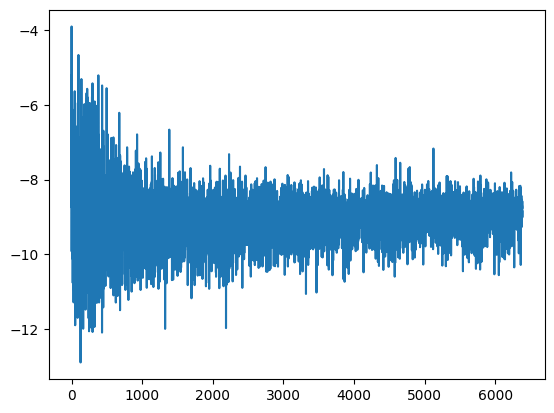

In [23]:
import matplotlib.pyplot as plt
# prob[0].shape
plt.plot(prob[0].detach().numpy())

In [ ]:
model_txt = (" ".join([vocab_tgt.get_itos()[x] for x in model_out if x != pad_idx]
            ).split(eos_string, 1)[0]+ eos_string)

print("Source Text (Input): "+ " ".join(src_tokens).replace("\n", ""))
print("Target Text (Ground Truth) : "+ " ".join(tgt_tokens).replace("\n", ""))
print("Model Output : " + model_txt.replace("\n", ""))

# Encode

In [ ]:
memory = model.encode(vocab_src, None)

# Down-brake **Model.encode(src, src_mask)**

In [ ]:
src = vocab_src
src.shape

## Step 1 Embeddings

In [ ]:
emb = Embeddings(vocab=FRENCH, d_model=D_MODEL)
x = emb(x)
x.shape

## Step 2 PositionEncoding(d_model, max_len)

In [ ]:
MAX_LEN = 5000
pos_enc = PositionalEncoding(d_model=D_MODEL, dropout=DROPOUT, max_len=MAX_LEN)
x = pos_enc(x)
x.shape

+ Start step 3 ResidualConnection (input 3)
## Step 4 MultiHeadedAttention

In [ ]:
attn = MultiHeadedAttention(h=H, d_model=D_MODEL)

### Step 4.1 Query, Key, Value

In [ ]:
# MultiHeadedAttention.__init__
d_head = D_MODEL // H
h = H
q_fc = nn.Linear(D_MODEL, D_MODEL)
k_fc = nn.Linear(D_MODEL, D_MODEL)
v_fc = nn.Linear(D_MODEL, D_MODEL)
final_fc = nn.Linear(D_MODEL, D_MODEL)
dropout = nn.Dropout(p=DROPOUT)

input_3 = x
mask = src_mask

# MultiHeadedAttention.forward : compute Query, Key, Value
mask = mask.unsqueeze(1)
print('mask shape=',mask.shape)
n_batches = input_3.size(0) # 1

print('input.shape=', [mapa[e] for e in input_3.shape])
query = q_fc(input_3)
key = k_fc(input_3)
value = v_fc(input_3)

print('query.shape=', [mapa[e] for e in query.shape])

### Step 4.2 Split to H heads

In [ ]:
# split data into H heads.
query = query.view(n_batches, n, h, d_head) .transpose(1, 2)
key = key.view(n_batches, n, h, d_head).transpose(1, 2)
value = value.view(n_batches, n, h, d_head).transpose(1, 2)
query.shape

### Step 4.3 Attention

In [ ]:
# def attention
key_t = key.transpose(-2, -1)
print('query.shape=', [mapa[e] for e in query.shape])
print('key_t.shape=', [mapa[e] for e in key_t.shape])

scores = torch.matmul(query, key_t) / math.sqrt(d_head)
print('scores.shape=', [mapa[e] for e in scores.shape])

scores = scores.masked_fill(mask, -1e9)

p_attn = scores.softmax(dim=-1)
print('p_attn.shape=', [mapa[e] for e in p_attn.shape])

# if dropout is not None:
#     p_attn = dropout(p_attn)

print('value.shape=', [mapa[e] for e in value.shape])
headed_context = torch.matmul(p_attn, value)
print('headed_context.shape=', [mapa[e] for e in headed_context.shape])

context = headed_context.transpose(1,2).contiguous().view(n_batches, n, h * d_head)
print('context.shape=', [mapa[e] for e in context.shape])

output_4 = final_fc(context)
print('output_4.shape=', [mapa[e] for e in output_4.shape])

## Step 5 LayerNorm

In [ ]:
norm = LayerNorm(D_MODEL)
output_5 = norm(output_4)
print('output_5.shape=', [mapa[e] for e in output_5.shape])

## Step 3 Residual Connectnion (output 3)

In [ ]:
# end ResidualConnection
output_3 = input_3 + output_5
print('output_3.shape=', [mapa[e] for e in output_3.shape])

+ Start Step 6 Residual Connecction (input 6)

## Step 7 PositionalWiseFeedForward

In [ ]:
w_1 = nn.Linear(D_MODEL, D_FF)
w_2 = nn.Linear(D_FF, D_MODEL)

fc1 = w_1(output_3).relu() # + DropOut
print('fc1.shape=', [mapa[e] for e in fc1.shape])
output_7 = w_2(fc1)
print('output_7.shape=', [mapa[e] for e in output_7.shape])

## Step 8 LayerNorm

In [ ]:
norm = LayerNorm(D_MODEL)
output_8 = norm(output_7)
print('output_8.shape=', [mapa[e] for e in output_8.shape])

## Step 6 ResidualConnection

In [ ]:
output_6 = output_8 + output_3

## Step 9 : Repeat N times loop Step3-Step8

# Decode

In [5]:
tgt = torch.zeros(1, 1).type_as(src)

for i in range(9):
    tgt_mask = following_mask(tgt.size(1)).type_as(src.data)

    out = test_model.decode(memory, src_mask, tgt, tgt_mask)

    prob = test_model.generator(out[:, -1])

    next_word = torch.argmax(prob, dim=1).unsqueeze(0)

    tgt=torch.cat([tgt, next_word],dim=1)

print("Example Untrained Model Prediction:", tgt)

Example Untrained Model Prediction: tensor([[0, 2, 7, 2, 2, 2, 2, 2, 2, 2]])


# Down-brake **Model.decode(memory, src_mask, tgt, tgt_mask)**

# Down-brake **Predict next word**

In [6]:
tgt = torch.zeros(1, 1).type_as(src)
tgt_mask = following_mask(tgt.size(1)).type_as(src.data)

prob = test_model.generator(out[:, -1])
ext_word = torch.argmax(prob, dim=1).unsqueeze(0)

tgt=torch.cat([tgt, next_word],dim=1)
tgt


tensor([[0, 2]])